In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import differential_evolution
import time
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # This allows us to import from the parent directory
from core_framework.model import OSELM, AdaptiveEnsemble

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Data Loading and Preparation
def create_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2023-12-31")
price_data = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price_data = scaler.fit_transform(price_data)

look_back = 10
X, y = create_dataset(scaled_price_data.flatten(), look_back)

initial_train_size = 100
X_initial_train, y_initial_train = X[:initial_train_size], y[:initial_train_size]
X_online, y_online = X[initial_train_size:], y[initial_train_size:]

print(f"Shape of initial training data (X): {X_initial_train.shape}")
print(f"Shape of online simulation data (X): {X_online.shape}")

C:\Users\ASUS-PLUS\AppData\Local\Temp\ipykernel_26480\2291652971.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Shape of initial training data (X): (100, 10)
Shape of online simulation data (X): (896, 10)


In [4]:
# Cell 3: Definition of the Dual-Objective Fitness Function
THETA = 0.7

def fitness_function(hyperparams):
    n_learners = int(hyperparams[0])
    window_size = int(hyperparams[1])
    n_hidden = int(hyperparams[2])
    C = hyperparams[3]
    alpha = hyperparams[4]

    model = AdaptiveEnsemble(
        n_learners=n_learners,
        window_size=window_size,
        n_hidden=n_hidden,
        C=C,
        alpha=alpha
    )

    start_time = time.time()
    model.fit(X_initial_train, y_initial_train)
    end_time = time.time()
    training_time = end_time - start_time
    f_speed = training_time

    predictions = model.predict(X_initial_train)
    rmse_error = np.sqrt(np.mean((predictions - y_initial_train)**2))
    f_accuracy = rmse_error
    
    final_fitness_score = (THETA * f_accuracy) + ((1 - THETA) * f_speed)

    print(f"Params: [Learners:{n_learners}, Win:{window_size}, Hidden:{n_hidden}] -> Fitness: {final_fitness_score:.4f} (RMSE:{rmse_error:.4f}, Time:{training_time:.4f}s)")
    
    return final_fitness_score

In [7]:
# Cell 4: Running the Optimization Process with DE (نسخه کامل برای بهینه‌سازی ۵ پارامتر)

# bounds برای هر ۵ هایپرپارامتری که قرار است بهینه شوند.
# ترتیب: [n_learners, window_size, n_hidden, C, alpha]
bounds = [
    (3, 15),         # Number of learners (M)
    (10, 100),       # Window size (W)
    (10, 300),       # Number of hidden neurons (L)
    (1e-5, 1e5),     # Regularization coefficient (C)
    (0.1, 5.0)       # Trust sensitivity (alpha)
]

# ثابت THETA برای تابع هدف
THETA = 0.7

# تابع fitness کامل که ۵ هایپرپارامتر را به عنوان ورودی دریافت می‌کند
def fitness_function_full(hyperparams):
    # Unpacking all 5 hyperparameters from the input array
    n_learners = int(hyperparams[0])
    window_size = int(hyperparams[1])
    n_hidden = int(hyperparams[2])
    C = hyperparams[3]
    alpha = hyperparams[4]

    # ساخت مدل با هایپرپارامترهای پیشنهادی
    model = AdaptiveEnsemble(
        n_learners=n_learners,
        window_size=window_size,
        n_hidden=n_hidden,
        C=C,
        alpha=alpha
    )

    # محاسبه زمان آموزش
    start_time = time.time()
    model.fit(X_initial_train, y_initial_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    # --- نرمال‌سازی (Normalization) ---
    # این مقادیر تخمینی به نرمال‌سازی کمک می‌کنند تا مقایسه بین دقت و سرعت منصفانه باشد
    max_expected_rmse = 0.1 # برای داده‌های scale شده بین 0 و 1
    max_expected_time = 1.0 # به ثانیه
    
    # محاسبه متریک‌های عملکرد
    predictions = model.predict(X_initial_train)
    rmse_error = np.sqrt(np.mean((predictions - y_initial_train)**2))

    # اگر مدل به دلیل پارامترهای نامناسب خروجی NaN داد، یک جریمه بزرگ در نظر می‌گیریم
    # این کار از بروز خطا در حین بهینه‌سازی جلوگیری می‌کند
    if np.isnan(rmse_error):
        return 1e10  # یک مقدار جریمه بسیار بزرگ

    # نرمال‌سازی متریک‌ها به بازه تقریبی [0, 1]
    f_accuracy_norm = min(rmse_error / max_expected_rmse, 1.0)
    f_speed_norm = min(training_time / max_expected_time, 1.0)

    # استفاده از فرمول هدف دوگانه (Dual-Objective)
    final_fitness_score = (THETA * f_accuracy_norm) + ((1 - THETA) * f_speed_norm)

    # چاپ نتایج برای هر ارزیابی (برای مانیتور کردن فرآیند)
    print(f"Params: [Learners:{n_learners}, Win:{window_size}, Hidden:{n_hidden}, C:{C:.2e}, Alpha:{alpha:.2f}] -> Fitness: {final_fitness_score:.4f} (RMSE:{rmse_error:.4f}, Time:{training_time:.4f}s)")
    
    return final_fitness_score


# --- شروع فرآیند بهینه‌سازی ---
print("Starting Differential Evolution optimization for all 5 hyperparameters...")
print(f"Optimization bounds (M, W, L, C, alpha): {bounds}")
print("-" * 50)

# فراخوانی الگوریتم بهینه‌سازی با تابع و بازه‌های درست
result = differential_evolution(
    func=fitness_function_full,  # تابع هدفی که باید کمینه شود
    bounds=bounds,               # بازه‌های مجاز برای هر هایپرپارامتر
    maxiter=10,                  # تعداد نسل‌ها (تکرارها)
    popsize=20,                  # اندازه جمعیت در هر نسل
    updating='immediate',
    disp=True,                   # نمایش پیشرفت فرآیند
    seed=42                      # برای تکرارپذیری نتایج
)

# --- پایان فرآیند بهینه‌سازی ---
print("-" * 50)
print("Optimization finished!")
print("\nBest hyperparameters found (M, W, L, C, alpha):")
print(result.x)

# ذخیره کردن بهترین هایپرپارامترهای پیدا شده
best_hyperparams = result.x

Starting Differential Evolution optimization for all 5 hyperparameters...
Optimization bounds (M, W, L, C, alpha): [(3, 15), (10, 100), (10, 300), (1e-05, 100000.0), (0.1, 5.0)]
--------------------------------------------------
Params: [Learners:14, Win:50, Hidden:253, C:6.43e+04, Alpha:0.46] -> Fitness: 0.2155 (RMSE:0.0115, Time:0.4510s)
Params: [Learners:8, Win:42, Hidden:53, C:5.61e+04, Alpha:1.98] -> Fitness: 0.0927 (RMSE:0.0132, Time:0.0000s)
Params: [Learners:7, Win:91, Hidden:272, C:2.05e+04, Alpha:4.15] -> Fitness: 0.1157 (RMSE:0.0126, Time:0.0925s)
Params: [Learners:5, Win:73, Hidden:261, C:9.26e+04, Alpha:0.21] -> Fitness: 0.1038 (RMSE:0.0111, Time:0.0867s)
Params: [Learners:8, Win:67, Hidden:137, C:3.59e+04, Alpha:3.53] -> Fitness: 0.1022 (RMSE:0.0128, Time:0.0422s)
Params: [Learners:13, Win:40, Hidden:207, C:8.61e+04, Alpha:3.86] -> Fitness: 0.1026 (RMSE:0.0115, Time:0.0737s)
Params: [Learners:5, Win:88, Hidden:189, C:8.54e+04, Alpha:0.84] -> Fitness: 0.0930 (RMSE:0.0117, 

--- Starting Online Simulation with Best Found Hyperparameters ---

Optimal Hyperparameters from DE (conforming to the paper's methodology):
 - M (Number of Learners): 3
 - W (Window Size): 78
 - L (Hidden Neurons): 236
 - C (Regularization): 9.1993e+04
 - alpha (Trust Sensitivity): 4.9824

Fitting the final model on initial training data...
Initial fitting complete.
Starting the online learning simulation...
Online simulation finished in 12.38 seconds.

Online Phase RMSE: $2.6343


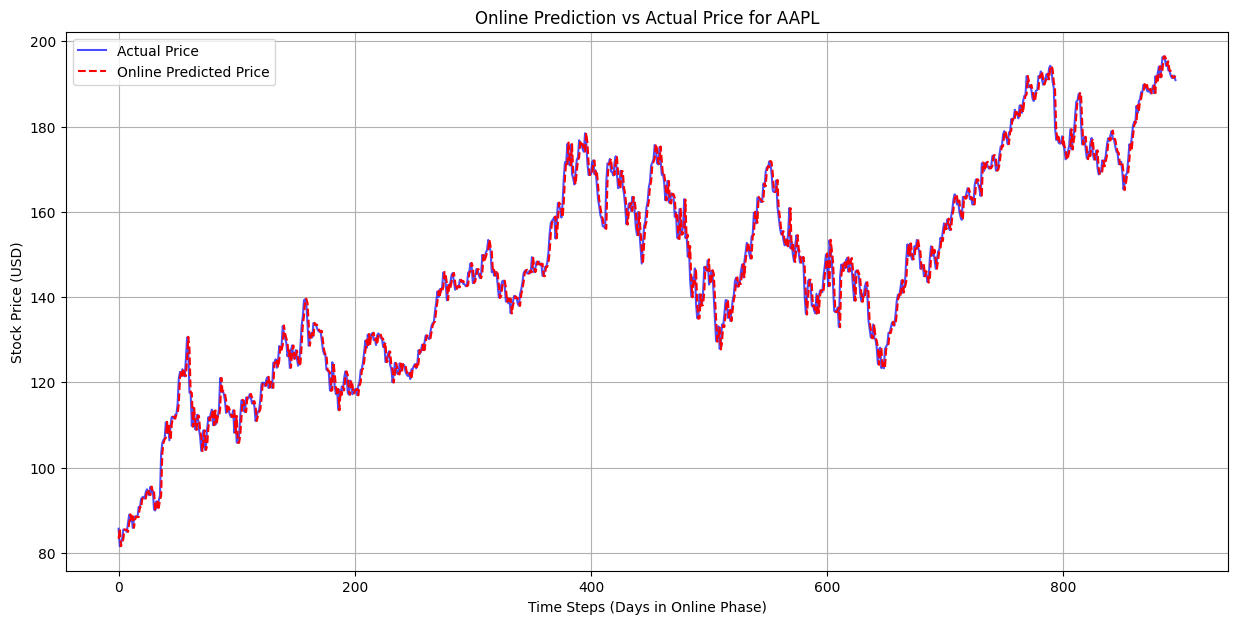

In [14]:
# Cell 5: Online Simulation with Best Hyperparameters (نسخه نهایی هماهنگ با مقاله)

print("--- Starting Online Simulation with Best Found Hyperparameters ---")

# --- استخراج هایپرپارامترهای بهینه از خروجی بهینه‌ساز ---
# اطمینان حاصل کنید ترتیب استخراج با ترتیب تعریف شده در `bounds` سلول ۴ یکسان است.
# فرض بر این است که ترتیب [M, W, L, C, alpha] است.
best_n_learners = int(best_hyperparams[0])
best_window_size = int(best_hyperparams[1])
best_n_hidden = int(best_hyperparams[2])
best_C = best_hyperparams[3]
best_alpha = best_hyperparams[4]

print("\nOptimal Hyperparameters from DE (conforming to the paper's methodology):")
print(f" - M (Number of Learners): {best_n_learners}")
print(f" - W (Window Size): {best_window_size}")
print(f" - L (Hidden Neurons): {best_n_hidden}")
print(f" - C (Regularization): {best_C:.4e}")
print(f" - alpha (Trust Sensitivity): {best_alpha:.4f}")

# ساخت مدل نهایی با استفاده از بهترین پارامترهای یافت‌شده
final_model = AdaptiveEnsemble(
    n_learners=best_n_learners,
    window_size=best_window_size,
    n_hidden=best_n_hidden,
    C=best_C,
    alpha=best_alpha
)

# 1. آموزش اولیه مدل روی داده‌های اولیه (همانطور که در فاز آفلاین مقاله ذکر شده)
print("\nFitting the final model on initial training data...")
final_model.fit(X_initial_train, y_initial_train)
print("Initial fitting complete.")

# 2. شبیه‌سازی فاز استقرار آنلاین (Online Deployment Phase)
print("Starting the online learning simulation...")
online_predictions = []
online_actuals = []

start_time_online = time.time()

# این حلقه دقیقاً همان فرآیند "استقرار آنلاین" را که در شکل ۱ مقاله شما
# نمایش داده شده، پیاده‌سازی می‌کند.
for i in range(len(X_online)):
    # دریافت داده جریانی جدید
    current_X = X_online[i].reshape(1, -1)
    current_y = y_online[i]
    
    # مرحله ۱: پیش‌بینی قیمت برای گام زمانی بعدی (t+1) با استفاده از مدل فعلی
    prediction = final_model.predict(current_X)
    
    # مرحله ۲: به‌روزرسانی مدل (وزن‌ها و ...) با استفاده از داده جدیدی که رسید
    # این معادل یادگیری ترتیبی (sequential) در OS-ELM است
    final_model.fit(current_X, np.array([current_y]))
    
    # ذخیره پیش‌بینی و مقدار واقعی
    online_predictions.append(prediction[0])
    online_actuals.append(current_y)

end_time_online = time.time()
print(f"Online simulation finished in {end_time_online - start_time_online:.2f} seconds.")

# 3. محاسبه و نمایش نتایج (این بخش از کد بدون تغییر باقی می‌ماند)
online_predictions = np.array(online_predictions)
online_actuals = np.array(online_actuals)

# برگرداندن داده‌ها از حالت scale شده به حالت واقعی قیمت
online_predictions_rescaled = scaler.inverse_transform(online_predictions.reshape(-1, 1))
online_actuals_rescaled = scaler.inverse_transform(online_actuals.reshape(-1, 1))

# محاسبه خطای RMSE در فاز آنلاین
online_rmse = np.sqrt(np.mean((online_predictions_rescaled - online_actuals_rescaled)**2))
print(f"\nOnline Phase RMSE: ${online_rmse:.4f}")

# 4. رسم نمودار نتایج برای تحلیل بصری
plt.figure(figsize=(15, 7))
plt.plot(online_actuals_rescaled, label='Actual Price', color='blue', alpha=0.7)
plt.plot(online_predictions_rescaled, label='Online Predicted Price', color='red', linestyle='--')
plt.title(f'Online Prediction vs Actual Price for {ticker}')
plt.xlabel('Time Steps (Days in Online Phase)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()